In [282]:
import pandas as pd
import pycountry
from afinn import Afinn
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

# PREPROCESSING

1 - data points needed: -location is USA -language is en -text
2 - remove URL, mentions, hashtags, special characters, stop words
3 - convert all text to lowercase 
4 - perform lemmatization 

In [283]:
!ls

 1_4_2022.csv  'April 1 2022 .ipynb'


In [284]:
df = pd.read_csv("1_4_2022.csv", low_memory=False)

In [285]:
df.head()

,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,coordinates,favorite_count,extractedts
0,0,16882774,Yaniela,"Animal lover, supports those who fight injusti...",Hawaii,1158,392,88366,2008-10-21 07:34:04.000000,1509681950042198030,2022-04-01 00:00:00.000000,3412,⚡The Ukrainian Air Force would like to address...,[],en,NaN,0,2022-04-01 00:44:20.097867
1,1,3205296069,gregffff,NaN,NaN,122,881,99853,2015-04-25 11:24:34.000000,1509681950151348229,2022-04-01 00:00:00.000000,100,Chernihiv oblast. Ukrainians welcome their lib...,"[{'text': 'russianinvasion', 'indices': [77, 9...",en,NaN,0,2022-04-01 00:09:37.148770
2,2,1235940869812809728,ThanapornThon17,เล่นไวโอลิน\nพูดภาษาจีน,NaN,231,72,5481,2020-03-06 14:52:01.000000,1509681950683926556,2022-04-01 00:00:00.000000,9,America 🇺🇸 is preparing for something worse th...,"[{'text': 'RussianUkrainianWar', 'indices': [7...",en,NaN,0,2022-04-01 00:09:37.125654
3,3,1347985375566966784,I_Protest_2021,01000001 01101110 01101111 01101110 01111001 0...,International Web Zone,399,377,301,2021-01-09 19:15:44.000000,1509681951116046336,2022-04-01 00:00:00.000000,573,JUST IN: #Anonymous has hacked &amp; released ...,"[{'text': 'Anonymous', 'indices': [25, 35]}]",en,NaN,0,2022-04-01 00:31:39.674382
4,4,1505394816636846083,Marsh_Win_01,🌿@Pickaw @TWITTERPICKER 🌿Winning isn’t everyth...,Hunter Account,158,25,8982,2022-03-20 04:04:40.000000,1509681951304990720,2022-04-01 00:00:00.000000,190,***PUBLIC MINT NOW LIVE***\n\nFor \n@billionai...,[],en,NaN,0,2022-04-01 00:09:37.101459


In [286]:
usa_states = [state.name.lower() for state in pycountry.subdivisions if state.country_code == 'US']

In [287]:
usa_states

['alaska',
 'alabama',
 'arkansas',
 'american samoa',
 'arizona',
 'california',
 'colorado',
 'connecticut',
 'district of columbia',
 'delaware',
 'florida',
 'georgia',
 'guam',
 'hawaii',
 'iowa',
 'idaho',
 'illinois',
 'indiana',
 'kansas',
 'kentucky',
 'louisiana',
 'massachusetts',
 'maryland',
 'maine',
 'michigan',
 'minnesota',
 'missouri',
 'northern mariana islands',
 'mississippi',
 'montana',
 'north carolina',
 'north dakota',
 'nebraska',
 'new hampshire',
 'new jersey',
 'new mexico',
 'nevada',
 'new york',
 'ohio',
 'oklahoma',
 'oregon',
 'pennsylvania',
 'puerto rico',
 'rhode island',
 'south carolina',
 'south dakota',
 'tennessee',
 'texas',
 'united states minor outlying islands',
 'utah',
 'virginia',
 'virgin islands, u.s.',
 'vermont',
 'washington',
 'wisconsin',
 'west virginia',
 'wyoming']

In [288]:
def extract_usa_location(location):
    if pd.isna(location): 
        return ""
    for state in usa_states:
        if state in location.lower():
            return location
    return ""

df["location"] = df["location"].fillna("")
df["location"] = df["location"].astype(str) 
usa_locations = df["location"].apply(extract_usa_location).loc[lambda x: x != ""] 

In [289]:
usa_locations

0                       Hawaii
34             New Jersey, USA
57               New York City
76               Washington DC
103                    Florida
                  ...         
364826          Washington, DC
364839    Colorado Springs, CO
364856              California
364863            Florida, USA
364868      Oakland California
Name: location, Length: 17539, dtype: object

In [290]:
location_is_usa = usa_locations.index

In [291]:
len(location_is_usa)

17539

In [292]:
print(location_is_usa)

Int64Index([     0,     34,     57,     76,    103,    111,    118,    127,
               140,    154,
            ...
            364724, 364760, 364762, 364783, 364793, 364826, 364839, 364856,
            364863, 364868],
           dtype='int64', length=17539)


In [293]:
def language_check(language):
    if pd.isna(language): 
        return False
    if language == 'en':
        return True
    else:
        return False

In [294]:
language_is_en = df[df['language'].apply(language_check)].index

In [295]:
language_is_en

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            364860, 364861, 364863, 364864, 364865, 364866, 364869, 364871,
            364872, 364874],
           dtype='int64', length=254626)

In [296]:
is_in = language_is_en.isin(location_is_usa)
both_usa_en = language_is_en[is_in]

In [297]:
print(both_usa_en)

Int64Index([     0,     34,     57,     76,    103,    111,    118,    127,
               140,    154,
            ...
            364705, 364724, 364760, 364762, 364783, 364793, 364826, 364839,
            364856, 364863],
           dtype='int64', length=15936)


In [298]:
df = df.iloc[both_usa_en]

In [299]:
df.head()

,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,coordinates,favorite_count,extractedts
0,0,16882774,Yaniela,"Animal lover, supports those who fight injusti...",Hawaii,1158,392,88366,2008-10-21 07:34:04.000000,1509681950042198030,2022-04-01 00:00:00.000000,3412,⚡The Ukrainian Air Force would like to address...,[],en,NaN,0,2022-04-01 00:44:20.097867
34,34,1269660949776158720,Retractionmedia,Jaime & Antoine debate politics & ponder scien...,"New Jersey, USA",1981,2181,7813,2020-06-07 16:02:26.000000,1509681971563319300,2022-04-01 00:00:05.000000,0,Jaime and Antoine discuss their initial reacti...,"[{'text': 'Ukraine', 'indices': [72, 80]}, {'t...",en,NaN,0,2022-04-01 00:14:21.299468
57,57,1497663382543081472,UkrainkaDarusia,artist - adventurer - truth seeker - mother- wife,New York City,51,2,242,2022-02-26 20:02:51.000000,1509681996624240646,2022-04-01 00:00:11.000000,0,"@DivorcedNy @juliaioffe In this case, the vodk...","[{'text': 'Ukraine', 'indices': [91, 99]}, {'t...",en,NaN,0,2022-04-01 00:14:21.132055
76,76,2882807331,SasakawaUSA,Sasakawa Peace Foundation USA is dedicated to ...,Washington DC,5402,6611,14482,2014-11-18 16:55:17.000000,1509682023425839105,2022-04-01 00:00:17.000000,0,Japan said it will send Foreign Minister Hayas...,"[{'text': 'Ukraine', 'indices': [191, 199]}]",en,NaN,0,2022-04-01 00:14:21.023750
103,103,67663087,KindnessLives,"I live in gratitude. Author of Muscle Hugs, a ...",Florida,187,108,22559,2009-08-21 17:24:07.000000,1509682055126429696,2022-04-01 00:00:25.000000,3,The order came five weeks into #Russia's invas...,"[{'text': 'Russia', 'indices': [51, 58]}, {'te...",en,NaN,0,2022-04-01 00:14:20.851510


In [300]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
mention_pattern = re.compile(r'@\w+')
hashtag_pattern = re.compile(r'#\w+')

In [301]:
def clean_text(text):
    text = url_regex.sub('', text)
    text = mention_regex.sub('', text)
    text = hashtag_regex.sub('', text)
    text = special_char_regex.sub('', text) 
    text = text.lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    text = text.strip()
    return text

In [302]:
df['text']

0         ⚡The Ukrainian Air Force would like to address...
34        Jaime and Antoine discuss their initial reacti...
57        @DivorcedNy @juliaioffe In this case, the vodk...
76        Japan said it will send Foreign Minister Hayas...
103       The order came five weeks into #Russia's invas...
                                ...                        
364793    Yesterday I cried more than in all the other 3...
364826    @TurboKitty @TJewel_N_Exile @_RL_W @codeg1rl @...
364839    The latest on the war in #Ukraine:\n\n➡️ Kyiv ...
364856    The Armed Forces of Ukraine seized Russian mil...
364863    The latest on the war in #Ukraine:\n\n➡️ Kyiv ...
Name: text, Length: 15936, dtype: object

In [303]:
df.loc[:, 'text'] = df['text'].apply(clean_text)

In [304]:
df['text']

0         ukrainian air force would like address misinfo...
34        jaime antoine discus initial reaction ukraine ...
57        case vodka shitty vodka aka horilka originated...
76        japan said send foreign minister hayashi polan...
103       order came five week invasion run fierce resis...
                                ...                        
364793    yesterday cried 36 day war husband colleague o...
364826    single country africa latin america asia excep...
364839    latest war kyiv denied conducting air strike r...
364856    armed force ukraine seized russian military eq...
364863    latest war kyiv denied conducting air strike r...
Name: text, Length: 15936, dtype: object

In [305]:
afinn = Afinn()

In [306]:
scores = [afinn.score(article) for article in df['text']]
sentiment = ['positive' if score > 0
                          else 'negative' if score < 0
                              else 'neutral'
                                  for score in scores]
     
score_table = pd.DataFrame()
score_table['topic'] =  df['text']
score_table['scores'] = scores
score_table['sentiments'] = sentiment
print(score_table)

                                                    topic  scores sentiments
0       ukrainian air force would like address misinfo...     4.0   positive
34      jaime antoine discus initial reaction ukraine ...    -3.0   negative
57      case vodka shitty vodka aka horilka originated...   -11.0   negative
76      japan said send foreign minister hayashi polan...     1.0   positive
103     order came five week invasion run fierce resis...    -1.0   negative
...                                                   ...     ...        ...
364793  yesterday cried 36 day war husband colleague o...   -11.0   negative
364826  single country africa latin america asia excep...     0.0    neutral
364839  latest war kyiv denied conducting air strike r...    -7.0   negative
364856  armed force ukraine seized russian military eq...    -2.0   negative
364863  latest war kyiv denied conducting air strike r...    -7.0   negative

[15936 rows x 3 columns]


In [307]:
df['sentiment_scores'] = scores

In [308]:
df['sentiments'] = sentiment

In [309]:
df

,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,coordinates,favorite_count,extractedts,sentiment_scores,sentiments
0,0,16882774,Yaniela,"Animal lover, supports those who fight injusti...",Hawaii,1158,392,88366,2008-10-21 07:34:04.000000,1509681950042198030,2022-04-01 00:00:00.000000,3412,ukrainian air force would like address misinfo...,[],en,NaN,0,2022-04-01 00:44:20.097867,4.0,positive
34,34,1269660949776158720,Retractionmedia,Jaime & Antoine debate politics & ponder scien...,"New Jersey, USA",1981,2181,7813,2020-06-07 16:02:26.000000,1509681971563319300,2022-04-01 00:00:05.000000,0,jaime antoine discus initial reaction ukraine ...,"[{'text': 'Ukraine', 'indices': [72, 80]}, {'t...",en,NaN,0,2022-04-01 00:14:21.299468,-3.0,negative
57,57,1497663382543081472,UkrainkaDarusia,artist - adventurer - truth seeker - mother- wife,New York City,51,2,242,2022-02-26 20:02:51.000000,1509681996624240646,2022-04-01 00:00:11.000000,0,case vodka shitty vodka aka horilka originated...,"[{'text': 'Ukraine', 'indices': [91, 99]}, {'t...",en,NaN,0,2022-04-01 00:14:21.132055,-11.0,negative
76,76,2882807331,SasakawaUSA,Sasakawa Peace Foundation USA is dedicated to ...,Washington DC,5402,6611,14482,2014-11-18 16:55:17.000000,1509682023425839105,2022-04-01 00:00:17.000000,0,japan said send foreign minister hayashi polan...,"[{'text': 'Ukraine', 'indices': [191, 199]}]",en,NaN,0,2022-04-01 00:14:21.023750,1.0,positive
103,103,67663087,KindnessLives,"I live in gratitude. Author of Muscle Hugs, a ...",Florida,187,108,22559,2009-08-21 17:24:07.000000,1509682055126429696,2022-04-01 00:00:25.000000,3,order came five week invasion run fierce resis...,"[{'text': 'Russia', 'indices': [51, 58]}, {'te...",en,NaN,0,2022-04-01 00:14:20.851510,-1.0,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364793,364793,833384574965182464,NeverBorg1,Writer/Novelist. Generally Anti-Labels. I beli...,"Maryland, USA",2796,2382,70412,2017-02-19 18:35:41.000000,1510044241061453824,2022-04-01 23:59:36.000000,4770,yesterday cried 36 day war husband colleague o...,[],en,NaN,0,2022-04-02 00:13:17.134664,-11.0,negative
364826,364826,15546192,WeActRadio,@wcp 2017 Best Social Justice Radio Station in...,"Washington, DC",52849,52527,128387,2008-07-22 23:31:01.000000,1510044271642132483,2022-04-01 23:59:44.000000,1,single country africa latin america asia excep...,"[{'text': 'Russia', 'indices': [285, 292]}, {'...",en,NaN,1,2022-04-02 00:13:16.555866,0.0,neutral
364839,364839,955306476,JcindyinA,"married to my husband, vegan, animal lover. Gn...","Colorado Springs, CO",303,358,125991,2012-11-18 11:28:44.000000,1510044290549903369,2022-04-01 23:59:48.000000,75,latest war kyiv denied conducting air strike r...,"[{'text': 'Ukraine', 'indices': [34, 42]}]",en,NaN,0,2022-04-02 00:13:16.480611,-7.0,negative
364856,364856,1243444955453878272,films4one1,NaN,California,553,15,9221,2020-03-27 07:49:50.000000,1510044310846140421,2022-04-01 23:59:53.000000,294,armed force ukraine seized russian military eq...,[],en,NaN,0,2022-04-02 00:34:39.610198,-2.0,negative


In [311]:
df['location'] = df['location'].str.lower()

In [312]:
df['location']

0                       hawaii
34             new jersey, usa
57               new york city
76               washington dc
103                    florida
                  ...         
364793           maryland, usa
364826          washington, dc
364839    colorado springs, co
364856              california
364863            florida, usa
Name: location, Length: 15936, dtype: object

In [313]:
def label_location(location):
    for state in usa_states:
        if state in location:
            return state.title()
    return location.title()

In [314]:
df['labeled_location'] = df['location'].apply(lambda x: label_location(x))

In [315]:
df

,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,...,retweetcount,text,hashtags,language,coordinates,favorite_count,extractedts,sentiment_scores,sentiments,labeled_location
0,0,16882774,Yaniela,"Animal lover, supports those who fight injusti...",hawaii,1158,392,88366,2008-10-21 07:34:04.000000,1509681950042198030,...,3412,ukrainian air force would like address misinfo...,[],en,NaN,0,2022-04-01 00:44:20.097867,4.0,positive,Hawaii
34,34,1269660949776158720,Retractionmedia,Jaime & Antoine debate politics & ponder scien...,"new jersey, usa",1981,2181,7813,2020-06-07 16:02:26.000000,1509681971563319300,...,0,jaime antoine discus initial reaction ukraine ...,"[{'text': 'Ukraine', 'indices': [72, 80]}, {'t...",en,NaN,0,2022-04-01 00:14:21.299468,-3.0,negative,New Jersey
57,57,1497663382543081472,UkrainkaDarusia,artist - adventurer - truth seeker - mother- wife,new york city,51,2,242,2022-02-26 20:02:51.000000,1509681996624240646,...,0,case vodka shitty vodka aka horilka originated...,"[{'text': 'Ukraine', 'indices': [91, 99]}, {'t...",en,NaN,0,2022-04-01 00:14:21.132055,-11.0,negative,New York
76,76,2882807331,SasakawaUSA,Sasakawa Peace Foundation USA is dedicated to ...,washington dc,5402,6611,14482,2014-11-18 16:55:17.000000,1509682023425839105,...,0,japan said send foreign minister hayashi polan...,"[{'text': 'Ukraine', 'indices': [191, 199]}]",en,NaN,0,2022-04-01 00:14:21.023750,1.0,positive,Washington
103,103,67663087,KindnessLives,"I live in gratitude. Author of Muscle Hugs, a ...",florida,187,108,22559,2009-08-21 17:24:07.000000,1509682055126429696,...,3,order came five week invasion run fierce resis...,"[{'text': 'Russia', 'indices': [51, 58]}, {'te...",en,NaN,0,2022-04-01 00:14:20.851510,-1.0,negative,Florida
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364793,364793,833384574965182464,NeverBorg1,Writer/Novelist. Generally Anti-Labels. I beli...,"maryland, usa",2796,2382,70412,2017-02-19 18:35:41.000000,1510044241061453824,...,4770,yesterday cried 36 day war husband colleague o...,[],en,NaN,0,2022-04-02 00:13:17.134664,-11.0,negative,Maryland
364826,364826,15546192,WeActRadio,@wcp 2017 Best Social Justice Radio Station in...,"washington, dc",52849,52527,128387,2008-07-22 23:31:01.000000,1510044271642132483,...,1,single country africa latin america asia excep...,"[{'text': 'Russia', 'indices': [285, 292]}, {'...",en,NaN,1,2022-04-02 00:13:16.555866,0.0,neutral,Washington
364839,364839,955306476,JcindyinA,"married to my husband, vegan, animal lover. Gn...","colorado springs, co",303,358,125991,2012-11-18 11:28:44.000000,1510044290549903369,...,75,latest war kyiv denied conducting air strike r...,"[{'text': 'Ukraine', 'indices': [34, 42]}]",en,NaN,0,2022-04-02 00:13:16.480611,-7.0,negative,Colorado
364856,364856,1243444955453878272,films4one1,NaN,california,553,15,9221,2020-03-27 07:49:50.000000,1510044310846140421,...,294,armed force ukraine seized russian military eq...,[],en,NaN,0,2022-04-02 00:34:39.610198,-2.0,negative,California


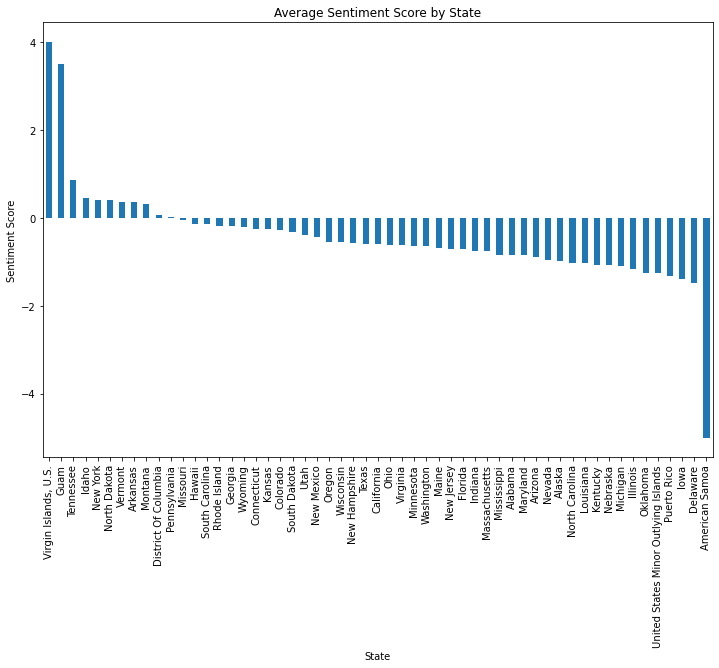

In [319]:
state_sentiment = df.groupby('labeled_location')['sentiment_scores'].mean()
state_sentiment_sorted = state_sentiment.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
state_sentiment_sorted.plot(kind='bar')
plt.title('Average Sentiment Score by State')
plt.xlabel('State')
plt.ylabel('Sentiment Score')
plt.show()

In [321]:
from wordcloud import WordCloud

In [322]:
text = ' '.join(df['text'].explode().dropna())

In [323]:
text

'ukrainian air force would like address misinformation published multiple western medium outlet regarding situation sky support ally 116 jaime antoine discus initial reaction ukraine crisis google apple case vodka shitty vodka aka horilka originated sloppy second like everything pathetic history fuck sooooo pathetic japan said send foreign minister hayashi poland place justice minister furukawa found covid19 close contact part effort assist fleeing due russian invasion via order came five week invasion run fierce resistance iaea director general arrived kaliningrad talk senior russian official tomorrow morning russian government acting wildly flawed assumption strategic detriment every indication suggests kremlin madness purely performative act read myth u providing needed weapon ally everything possible short direct involvement war truth date ally answered call air defense support fighter jet sam 1116 ukrainian air force would like address misinformation published multiple western med

In [324]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

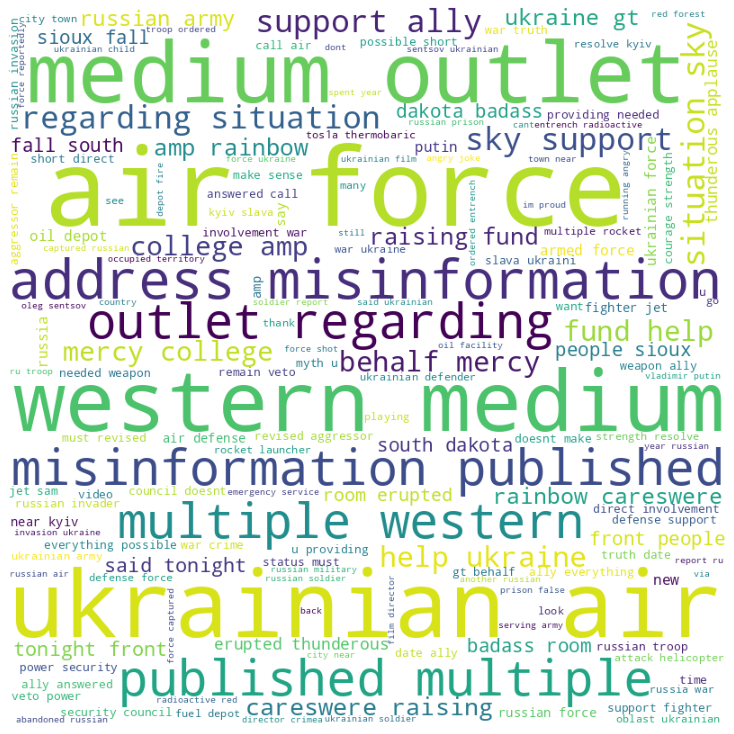

In [325]:
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()